In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sdv.single_table import TVAESynthesizer
from sdv.metadata import Metadata
from xgboost import XGBClassifier
from skopt import BayesSearchCV

pd.set_option('display.max_columns', None)


In [2]:
# Load data
df = pd.read_csv(
    "../../data/Angoss Knowledge Seeker - carclaims.txt/carclaims_original.csv"
)
# Drop row with missing data
df.drop(df[df["DayOfWeekClaimed"] == "0"].index, inplace=True)
# Drop ID column
df.drop(columns="PolicyNumber", inplace=True)
# df.drop(columns="Age", inplace=True)

# Train-test split
carclaims_train, carclaims_test = train_test_split(df, test_size=0.2, random_state=141)

In [3]:
# synthesizer = TVAESynthesizer.load(
#     filepath='my_synthesizer_92_8.pkl'
# )

# synthetic_data = synthesizer.sample(
#     num_rows=100_000,
#     batch_size=1_000
# )

X_train = carclaims_train.drop('FraudFound', axis=1)
y_train = carclaims_train['FraudFound']

X_test = carclaims_test.drop('FraudFound', axis=1)
y_test = carclaims_test['FraudFound']

# Encode target variable
y_train = y_train.map({'Yes': 1, 'No': 0})
y_test = y_test.map({'Yes': 1, 'No': 0})
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Label Encode features
column_labels = {
    'AgeOfPolicyHolder': ['16 to 17', '18 to 20', '21 to 25', '26 to 30', '31 to 35', '36 to 40', '41 to 50', '51 to 65', 'over 65'],
    'NumberOfSuppliments': ['none', '1 to 2', '3 to 5', 'more than 5'],
    'AddressChange-Claim': ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years'],
    'NumberOfCars': ['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8'],
    'VehiclePrice': ['less than 20,000', '20,000 to 29,000', '30,000 to 39,000', '40,000 to 59,000', '60,000 to 69,000', 'more than 69,000'],
    'Days:Policy-Accident': ['none', '1 to 7', '15 to 30', '8 to 15', 'more than 30'],
    'Days:Policy-Claim': ['15 to 30', '8 to 15', 'more than 30'],
    'PastNumberOfClaims': ['none', '1', '2 to 4', 'more than 4'],
    'AgeOfVehicle': ['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7'],
    'Deductible': [300, 400, 500, 700]
    }
for column, labels in column_labels.items():
    oe = OrdinalEncoder(categories=[labels], handle_unknown='error')
    X_train[column] = oe.fit_transform(X_train[[column]])
    X_test[column] = oe.transform(X_test[[column]])
    
# one hot encode
columns_one_hot = {
    'Make': ['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda', 'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson', 'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW'],
    'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'DayOfWeek': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    'DayOfWeekClaimed': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    'MonthClaimed': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'AccidentArea': ['Rural', 'Urban'],
    'Sex': ['Female', 'Male'],
    'MaritalStatus': ['Divorced', 'Married', 'Single', 'Widow'],
    'PoliceReportFiled': ['No', 'Yes'],
    'WitnessPresent': ['No', 'Yes'],
    'AgentType': ['External', 'Internal'],
    'BasePolicy': ['All Perils', 'Collision', 'Liability'],
    'Fault': ['Policy Holder', 'Third Party'],
    'PolicyType': ['Sedan - All Perils', 'Sedan - Collision', 'Sedan - Liability','Sport - All Perils', 'Sport - Collision', 'Sport - Liability', 'Utility - All Perils', 'Utility - Collision', 'Utility - Liability'],
    'VehicleCategory': ['Sedan', 'Sport', 'Utility'],
    'Year': [1994, 1995, 1996],
    #
    
}
for column, labels in columns_one_hot.items():
    ohe = OneHotEncoder(sparse_output=False, categories=[labels], drop='first', handle_unknown='error')
    encoded_nominal = ohe.fit_transform(X_train[[column]])
    X_train = pd.concat([X_train, pd.DataFrame(encoded_nominal, columns=ohe.get_feature_names_out([column]), index=X_train.index)], axis=1)
    encoded_nominal = ohe.transform(X_test[[column]])
    X_test = pd.concat([X_test, pd.DataFrame(encoded_nominal, columns=ohe.get_feature_names_out([column]), index=X_test.index)], axis=1)
X_test.drop(columns=columns_one_hot.keys(), axis=1, inplace=True)
X_train.drop(columns=columns_one_hot.keys(), axis=1, inplace=True)

In [4]:
# tsne_model = TSNE(learning_rate=1000)

# tsne_features = tsne_model.fit_transform(X_train)

In [5]:
# plt.figure(figsize=(8, 8))
# plt.scatter(tsne_features[:,0], tsne_features[:,1], c=y_train.map({0: 'green', 1: 'red'}), s=5)
# plt.show()

In [6]:
neighbors = NearestNeighbors(n_neighbors=180)
neighbors_fit = neighbors.fit(X_train)
distances, indices = neighbors_fit.kneighbors(X_train)

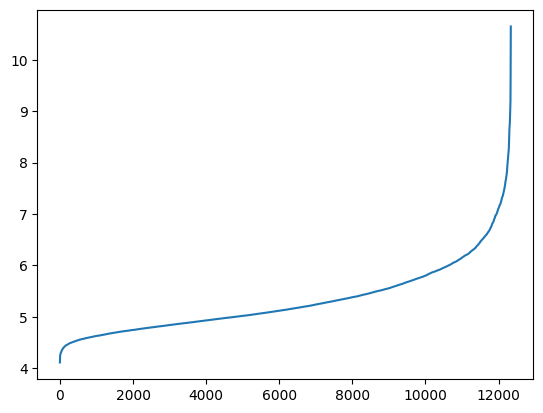

In [7]:
avg_distance = distances.mean(axis=1)
plt.plot(np.sort(avg_distance))

In [8]:
sc = DBSCAN(eps=6.5, min_samples=180)
clusters = pd.DataFrame(sc.fit_predict(X_train), columns=['Cluster'], index=X_train.index)
clusters['Cluster'].value_counts()

Cluster
 0    11763
-1      572
Name: count, dtype: int64

In [9]:
# colors = clusters['Cluster'].map({-1: 'red', 0: 'yellow', 1: 'green', 2: 'blue'})
# plt.figure(figsize=(8, 8))
# plt.scatter(tsne_features[:,0], tsne_features[:,1], c=colors, s=5)
# plt.show()

In [10]:
from sklearn.metrics import silhouette_score
# Optimal value for eps
eps = 6.5
 
# Range of values for min_samples to explore
min_samples_range = range(80, 200)
 
# Initialize a list to save silhouette scores
silhouette_scores = []
 
# Compute silhouette score for each min_samples value
for min_samples in min_samples_range:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_train)
    if len(np.unique(labels)) > 1:  # Ensure there are at least 2 clusters
        silhouette_avg = silhouette_score(X_train, labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(-1)  # Set a negative score if there's only one cluster
 
# Find the min_samples value with the maximum silhouette score
best_min_samples = min_samples_range[np.argmax(silhouette_scores)]
best_silhouette_score = max(silhouette_scores)
 
print(f"The best value for min_samples is {best_min_samples} with a silhouette score of {best_silhouette_score}")

The best value for min_samples is 175 with a silhouette score of 0.5343675273498789


In [11]:
opt = BayesSearchCV(
    XGBClassifier(),
    {
        'n_estimators': (2, 200),
        'max_depth': (2, 35),
        # 'gamma': (1e-6, 1e+1, 'log-uniform'),
        # 'reg_lambda': (1, 8, 'uniform'),
        # 'booster': ['gbtree', 'gblinear', 'dart'],
        # "tree_method": ['exact', 'approx', 'hist']
    },
    n_iter=10,
    cv=5,
    scoring='f1'
)

In [12]:
cls = clusters['Cluster'].unique()

models = {}
for c in cls:
    opt.fit(X_train[clusters['Cluster'] == c], y_train[clusters['Cluster'] == c])
    print(f'val. score for {c}: {opt.best_score_}')
    models[c] = opt.best_estimator_
    
models

val. score for 0: 0.14993887732644254
val. score for -1: 0.16825396825396824


{0: XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=8, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=129, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 -1: XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_ca

In [13]:
test_clusters = pd.DataFrame(sc.fit_predict(X_test), columns=["Cluster"], index=X_test.index)
test_results = X_test.copy()
test_results["Cluster"] = test_clusters["Cluster"]
test_results['Prediction'] = 0

# Iterate through clusters and test corresponding models
for c in test_clusters["Cluster"].unique():
    # Get data for the current cluster
    cluster_data = X_test[test_results["Cluster"] == c]
    
    if c in models:
        test_results.loc[cluster_data.index, 'Prediction'] = models[c].predict(cluster_data)
    else:
        print(f"No model available for cluster {c}.")
        
# Combine predictions
# predictions.sort(key=lambda x: x[0])  # Sort by index
final_predictions = test_results['Prediction']

# Evaluate performance
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.94
Precision: 0.40
Recall: 0.08
F1 Score: 0.13


In [15]:
test_clusters["Cluster"].unique()

array([ 0, -1])